In [53]:
import sys
sys.path.append("../../../../src")
import nanonets
import nanonets_utils
import matplotlib.pyplot as plt
import scienceplots
%matplotlib inline

plt.style.use(["science","bright"])

In [54]:
N_p                 = 9
topology_parameter  = {
    "Nx"                : N_p,
    "Ny"                : N_p,
    "Nz"                : 1,
    "e_pos"             : [[(N_p-1)//2,0,0],[0,0,0],[N_p-1,0,0],[0,(N_p-1)//2,0],
                          [N_p-1,(N_p-1)//2,0],[0,N_p-1,0],[N_p-1,N_p-1,0],[(N_p-1)//2,N_p-1,0]],
    "electrode_type"    : ['constant','constant','constant','constant','constant','constant','constant','floating']
}

def run_magic_cable(time_steps, voltages, topology_parameter, radius=1e6):

    np_info2 = {
        'np_index'      : [76], 
        'mean_radius'   : radius,
        'std_radius'    : 0.0
    }

    target_electrode    = len(topology_parameter["e_pos"])-1
    sim_class           = nanonets.simulation(topology_parameter=topology_parameter, np_info2=np_info2)
    sim_class.run_var_voltages(voltages=voltages, time_steps=time_steps, target_electrode=target_electrode, stat_size=10, save=False)
    results             = sim_class.return_output_values()

    return results

Text(0.5, 0, '$t$ [ns]')

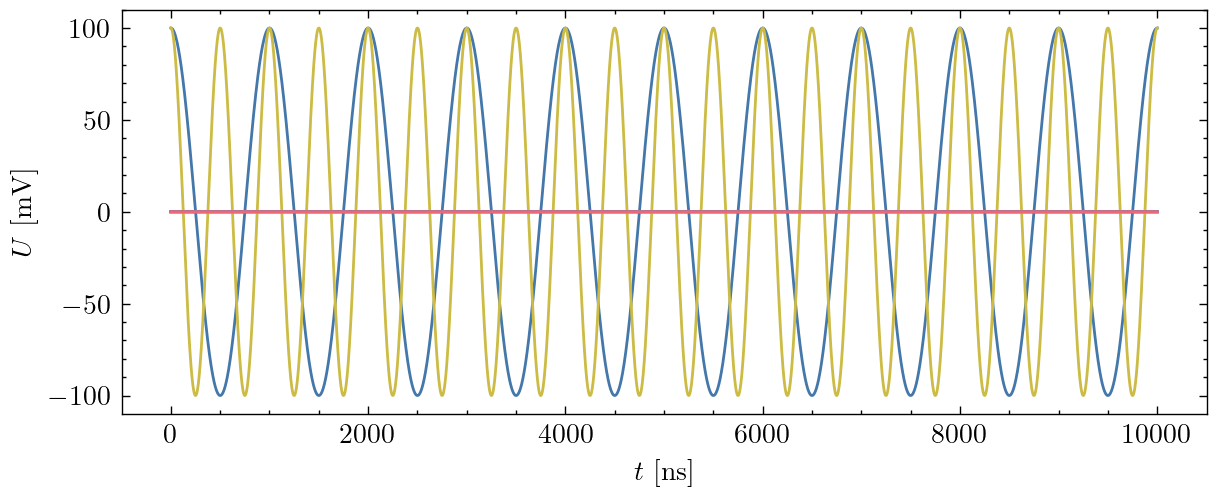

In [55]:
# Voltage Paramter
N_voltages              = 100000
amplitudes              = [0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0]
frequencies             = [1e6,0.0,0.0,2e6,0.0,0.0,0.0,0.0]
time_step               = 1e-9
time_steps, voltages    = nanonets_utils.sinusoidal_voltages(N_samples=N_voltages, topology_parameter=topology_parameter,
                                                             amplitudes=amplitudes, frequencies=frequencies)

fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot()
ax.plot(time_steps*1e9, voltages*1000)
ax.set_ylabel('$U$ [mV]')
ax.set_xlabel('$t$ [ns]')

In [56]:
radius_vals = [1e3]
results     = []
for radius in radius_vals:
    val     = run_magic_cable(time_steps, voltages, topology_parameter, radius)
    results.append(val)

Text(0, 0.5, 'Input [mV]')

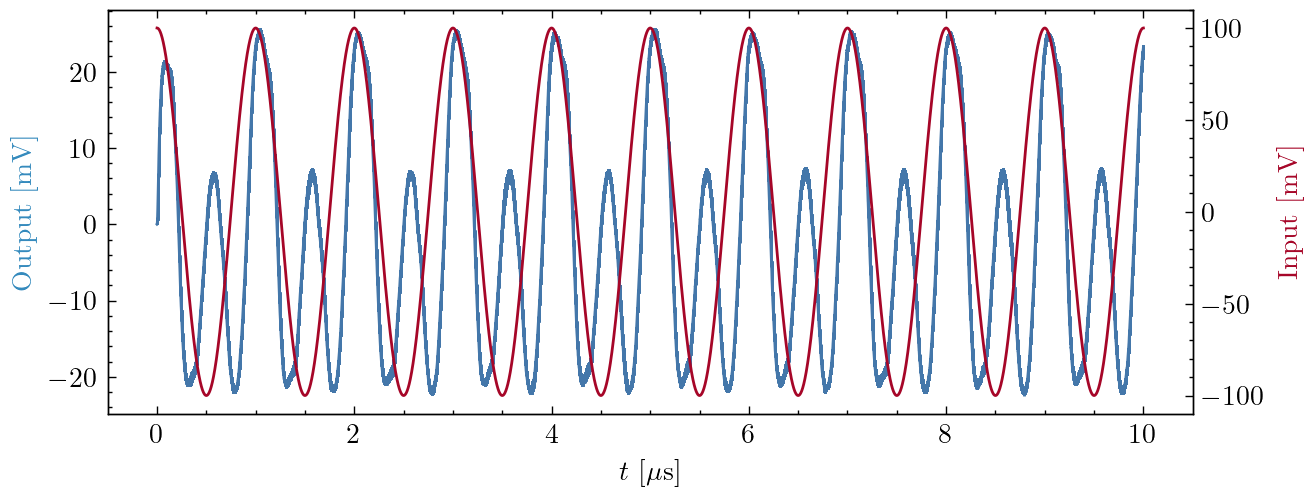

In [57]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot()
for i in range(len(radius_vals)):
    ax.errorbar(time_steps[:-1]*1e6, results[i][:,2]*1000, results[i][:,3]*1000)
ax.set_xlabel('$t$ [$\mu$s]')
ax.set_ylabel('Output [mV]',c=nanonets_utils.blue_color)

ax2 = ax.twinx()
ax2.plot(time_steps[:-1]*1e6,voltages[:-1,0]*1000,nanonets_utils.red_color)
ax2.set_ylabel('Input [mV]',c=nanonets_utils.red_color)